# Bayesian techniques for factor models

## Partial pooling for the CAPM

Bayesian hierarchical models, or partial pooling, have been gaining more relevance throughout the years. Ever since the benchmark "eight schools" study of Rubin (1981), hierarchical models have made their way into the Bayesian toolbox.

Partial pooling is particularly useful when our data comes into "clusters", and the assumption that the parameter for one cluster may contain useful information regarding others seems reasonable. 

The usual approaches either assume the data in different clusters comes from the same distribution (full pooling), or that the clusters are completely separate and do not contain information about each other (unpooled). 

In the case of partial pooling, we assume the data from each cluster is drawn from different parameters, but these parameters are drawn from the same distribution, thereby being called hierarchical.

In Rubin's eight schools example, Rubin sought to measure the effects of SAT-specific courses on students' outcomes when taking the SAT. The clusters were each of the schools where the courses were taught. Both the assumptions that the schools did not contain any information about each other, or that the students' outcomes in different schools were drawn from the exact same distribution seemed unreasonable.

We can try and apply partial pooling in the context of the cross section of returns

Remember the CAPM model: we describe the returns of each stock as a function of the market return. It turns out companies listed in the S&P 500 can be grouped into sectors. These could work as our clusters.

First we start off by scraping the return data from Yahoo Finance

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import pymc as pm
import arviz as az
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
companies = pd.read_csv("https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv")

tickers = companies["Symbol"]
tickers_list = tickers.tolist()
tickers_list[401] = "RVTY"
tickers_list = list(map(lambda x: str.replace(x, ".", "-"), tickers_list))

start_date = "2021-01-01"
end_date = "2023-12-30"

spy = yf.Ticker("SPY").history(start = start_date, end = end_date)
spy_ret = spy['Close'].pct_change().dropna()

returns_df = pd.DataFrame()
for i in tickers_list:
    price = yf.Ticker(i).history(start = start_date, end = end_date)
    ret = price['Close'].pct_change().dropna()
    # returns_df[i] = ret
    returns_df = pd.concat((returns_df, ret.rename(i)), axis=1)
returns_df.columns = tickers_list
returns_df.dropna(axis=1, inplace=True)
returns_df


KeyboardInterrupt



Now we shall set up a multilevel dataframe, with companies and sectors as levels

In [ ]:
drop_cols = []
for i in tickers_list:
    if i not in returns_df.columns:
        drop_cols.append(i)
drop_cols

companies_new = companies.drop(companies[companies["Symbol"].isin(drop_cols)].index).sort_values(by="GICS Sector")

tuples = list(zip(companies_new['GICS Sector'],companies_new['Symbol']))
columns = pd.MultiIndex.from_tuples(tuples, names=["GICS Sector", "Symbol"])

returns_df.columns = columns
returns_df

Recall the CAPM model for how companies' returns can be predicted by the market factor. We can estimate a CAPM model for each of the companies, therefore obtaining a market beta for every single company, or we could group them all together, obtaining a single beta for the whole S&P500. 

This last approach would be redundant, as our predictor variable (SPY) is already the returns for the S&P 500. In this case we would obtain an alpha very close to zero and a beta very close to 1. This approach, however, could be valid for a subset of the S&P 500 stocks. 

Or we could use the information that stocks are grouped into sectors and try to use the CAPM to estimate sector betas. We have already introduced Bayesian multilevel modelling, an approach that could be useful in this.

### Noncentered parametrization for multilevel models

Before jumping into our model, we also need to introduce one more aspect of Bayesian multilevel models: centered and noncentered parametrizations. A centered parametrization would be the intuitive way to specify a multilevel model. A simple centered multilevel model could look like

$\mu \sim N(0,1)$,

$\sigma \sim HalfCauchy(1)$,

$\beta_j \sim N(\mu,\sigma^2)$,

$y_{i,j} \sim N(\beta_j x_{i,j}, 1)$.

An MCMC sample might have trouble here because $\mu$ and $\beta_j$ can be correlated, so the sampler has issues exploring the parameter space. Ben Lambert gives a good overview of the problem here: https://www.youtube.com/watch?v=gSd1msFFZTw

We can improve things by using a noncentered parametrization, which would look like

$\mu \sim N(0,1)$,

$\sigma \sim HalfCauchy(1)$,

$Z_j \sim N(0,1)$,

$\beta_j = \mu + \sigma Z_j$,

$y_{i,j} \sim N(\beta_j x_{i,j}, 1)$.

The difference is mathematically subtle, but can have a lot of difference computationally. From probability theory we know how to standardize a normal distribution, and what we do here can be viewed as the reverse: instead of subtracting the mean and dividing by the standard deviation in order to obtain the standard normal, we start from the standard normal, multiply by the SD and add the mean to obtain our normally distributed variable. It turns out that, for the fact that $\mu$ and $Z_j$ are uncorrelated, the sampler has a much easier time exploring the parameter space. For a more thorough explanation see: https://twiecki.io/blog/2014/03/17/bayesian-glms-3/

Now let's specify our multilevel CAPM with sectors as clusters

In [ ]:
sector_list = companies_new["GICS Sector"].unique()
n_sectors = companies_new["GICS Sector"].nunique()
T = len(spy_ret)

sector_idxs, sectors = pd.factorize(companies_new["GICS Sector"].reset_index(drop=1))
coords = {
    "sector": sectors,
    "obs_id": np.arange(len(sector_idxs))
}

with pm.Model(coords=coords) as hierarchical_capm:
    
    sector_idx = pm.Data("sector_idx", sector_idxs, dims="obs_id", mutable=False)
   
    mu_alpha = pm.Normal("mu_alpha", 0, 1e2)
    sigma_alpha = pm.HalfCauchy("sigma_alpha", 1)
    mu_beta = pm.Normal("mu_beta", 0, 1e2)
    sigma_beta = pm.HalfCauchy("sigma_beta", 1)

    # centered:
    # alpha = pm.Normal("alpha", mu_alpha, sigma_alpha, dims="sector")
    # noncentered:
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * pm.Normal("z_alpha", 0,1, shape=n_sectors), dims="sector")
    
    # centered:
    # beta = pm.Normal("beta", mu_beta, sigma_beta, dims="sector")
    # noncentered:
    beta = pm.Deterministic("beta", mu_beta + sigma_beta * pm.Normal("z_beta", 0,1, shape=n_sectors), dims="sector")

    error = pm.HalfCauchy("error", 1)
    stock_return = alpha[sector_idx] + beta[sector_idx] * spy_ret.values.reshape((-1,1))
    
    y = pm.Normal('likelihood', mu = stock_return, sigma = error, observed = returns_df.values)
pm.model_to_graphviz(hierarchical_capm)

In [ ]:
with hierarchical_capm:
    trace_hcapm = pm.sample(2000, tune=1000, target_accept=0.8, return_inferencedata=True, chains=2)

In [ ]:
az.plot_trace(trace_hcapm, var_names=["~z_alpha", "~z_beta"])

In [ ]:
az.plot_density(trace_hcapm,var_names=["beta"],shade=0.1)
plt.show()

These posteriors for the market betas can give us an idea of which sectors are more or less sensitive to the market.

## Regularization methods for multifactor models

Going back to the multifactor models for the cross section of stock returns, such as the Fama-French 3 factor, Carhart 4 factor or APT models, we can try to evaluate the usefulness of each covariate in predicting stock returns. Nowadays, financial institutions might dispose of dozens, even hundreds of possible covariates for predicting returns. A linear model with too many variables, however, might lead to spurious relationships and/or overfitting. This is the problem known in machine learning as "feature selection".

Regularization methods are a way of solving this. Methods such as LASSO or ridge regression add a penalty to the regression function, "shrinking" coefficients towards zero. The purpose of this is so that more coefficients will equal zero, and less covariates will be deemed useful in predicting future observations. 

We already went through the fact that, in Bayesian inference, regularization can be imposed via prior distributions. This comes handy in the estimation of Bayesian factor models, especially with many covariates. 

In an article from 2015, Fama and French augment their traditional 3 factor model with two additional factors: profitability and investment. The "profitability" factor (RMW) stands for the premium for companies with robust profit margins minus weak profit margins. The "investment" factor (CMA) refers to companies' investment strategies regarding assets, and captures the premium for investing in companies with conservative investing minus aggressive ones.

We also include Carhart's momentum factor (MOM) and two factors proposed by researchers at AQR Capital Management, BAB and QMJ. Quality minus junk (QMJ), as presented by Asness, Frazzini and Pedersen, seeks to quantify the premium for investing in stocks with better quality measures, such as profitability, growth and safety, versus worse ("junk") ones. 

Betting against beta (BAB), presented by Frazzini and Pedersen, is based on a real-world deviation from CAPM predictions. The CAPM predicts that investors will divide their wealth between the risk-free rate and the market portfolio, and their risk preferences will dictate how much they will allocate between both, or even borrow at the risk-free rate to leverage themselves at the market portfolio, for risk-loving agents. In reality, there is a restriction to how much agents can borrow and leverage themselves, so risk-lovers who want more leverage end up buying assets with high market beta, which makes assets with low market betas cheaper. The BAB factor captures the premium for investing in low market beta assets, therefore "betting against beta".

Frazzini, Kabiller and Pedersen (https://www.tandfonline.com/doi/full/10.2469/faj.v74.n4.3) find that including QMJ and BAB as additional factors in the traditional 4 factor (market, SMB, HML and momentum) model reduces the annualized alpha obtained by Berkshire Hathaway from 5.3% to 0.3% for the period between 1976 and 2011. See https://www8.gsb.columbia.edu/valueinvesting/sites/valueinvesting/files/14%20-%20Summary%20of%20%20%27Buffett%27s%20Alpha%27.pdf for a summary

As for macroeconomic variables, we include CPI inflation (12-month), industrial capacity utilization, GDP growth, returns on 3 month T-bill rates, the term spread (10 year minus 3 month Treasury rates) and the economic policy uncertainty index by Baker, Bloom and Davis (https://www.policyuncertainty.com/index.html). We use the three component index and scale it dividing the values by 100.

Our variables shall have daily frequency. We shall use linear interpolation to convert variables that do not have daily frequency. All variables that are percentages are quoted in absolute values e.g. an inflation of 2% appears as 2 and not as 0.02.

In [3]:
ff5f = pd.read_csv("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip", skiprows=2, index_col=0)
ff5f.index = pd.to_datetime(ff5f.index, format="%Y%m%d")
ff5f.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2023-11-24,0.11,0.62,0.19,-0.51,0.24,0.021
2023-11-27,-0.23,-0.14,-0.08,0.12,-0.25,0.021
2023-11-28,0.06,-0.30,0.05,-0.17,0.02,0.021
2023-11-29,0.01,0.58,0.69,-0.78,-0.06,0.021
2023-11-30,0.35,-0.41,0.01,-0.11,0.19,0.021


In [4]:
mom = pd.read_csv("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip", skiprows=12, skipfooter=1, index_col=0, engine="python")
mom.index = pd.to_datetime(mom.index, format="%Y%m%d")
mom.columns = ["MOM"]

qmj = pd.read_excel("https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Quality-Minus-Junk-Factors-Daily.xlsx", skiprows=18, index_col=0, usecols="A,Y") * 100
qmj.index = pd.to_datetime(qmj.index, format="%m/%d/%Y")
qmj.columns = ["QMJ"]

bab = pd.read_excel("https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Betting-Against-Beta-Equity-Factors-Daily.xlsx", skiprows=18, index_col=0, usecols="A,Y") * 100
bab.index = pd.to_datetime(bab.index, format="%m/%d/%Y")
bab.columns = ["BAB"]

In [5]:
cpi_infl = pd.read_csv("https://api.db.nomics.world/v22/series/BLS/cu/CUSR0000SA0.csv", index_col = 0).pct_change(periods=12)["2010-01-01":] * 100
cpi_infl.index = pd.to_datetime(cpi_infl.index, format="%Y-%m")
cpi_infl.columns = ["CPI inflation"]
cpi_infl = cpi_infl.asfreq("D").interpolate()

cap_util = pd.read_csv("https://api.db.nomics.world/v22/series/FED/G17_CAPUTL/CAPUTL.B50001.S.csv", index_col = 0).apply(np.log)
cap_util.index = pd.to_datetime(cap_util.index, format="%Y-%m-%d")
cap_util.columns = ["Capacity utilization"]
cap_util = cap_util.asfreq("D").interpolate()

gdp_growth = pd.read_csv("https://api.db.nomics.world/v22/series/BEA/GDPbyIndustry-15/II-Q.csv", index_col = 0).pct_change() * 100
gdp_growth.index = pd.PeriodIndex(gdp_growth.index, freq='Q').to_timestamp()
gdp_growth.columns = ["GDP growth"]
gdp_growth = gdp_growth.asfreq("D").interpolate()

irx = pd.DataFrame((yf.Ticker("^IRX").history(period="max")["Close"]).rename("3 month T-bill", inplace=True))
irx.index = irx.index.tz_localize(None)

uncertainty = pd.read_excel("https://www.policyuncertainty.com/media/US_Policy_Uncertainty_Data.xlsx", skipfooter=1)
uncertainty['date'] = pd.to_datetime(uncertainty['Year'].astype(str) + "-" + uncertainty['Month'].astype(str), format="%Y-%m")
uncertainty.set_index('date', inplace=True)
uncertainty = pd.DataFrame(uncertainty["Three_Component_Index"])
uncertainty.columns = ["Uncertainty index"]
uncertainty = uncertainty.asfreq("D").interpolate() / 100

import pandas_datareader as pdr
term_spread = pdr.get_data_fred('T10Y3M').apply(pd.to_numeric, errors='coerce').interpolate()
term_spread.index = pd.to_datetime(term_spread.index, format="%Y%m%d")
term_spread.columns = ["Term spread"]
term_spread = term_spread.asfreq("D").interpolate()

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

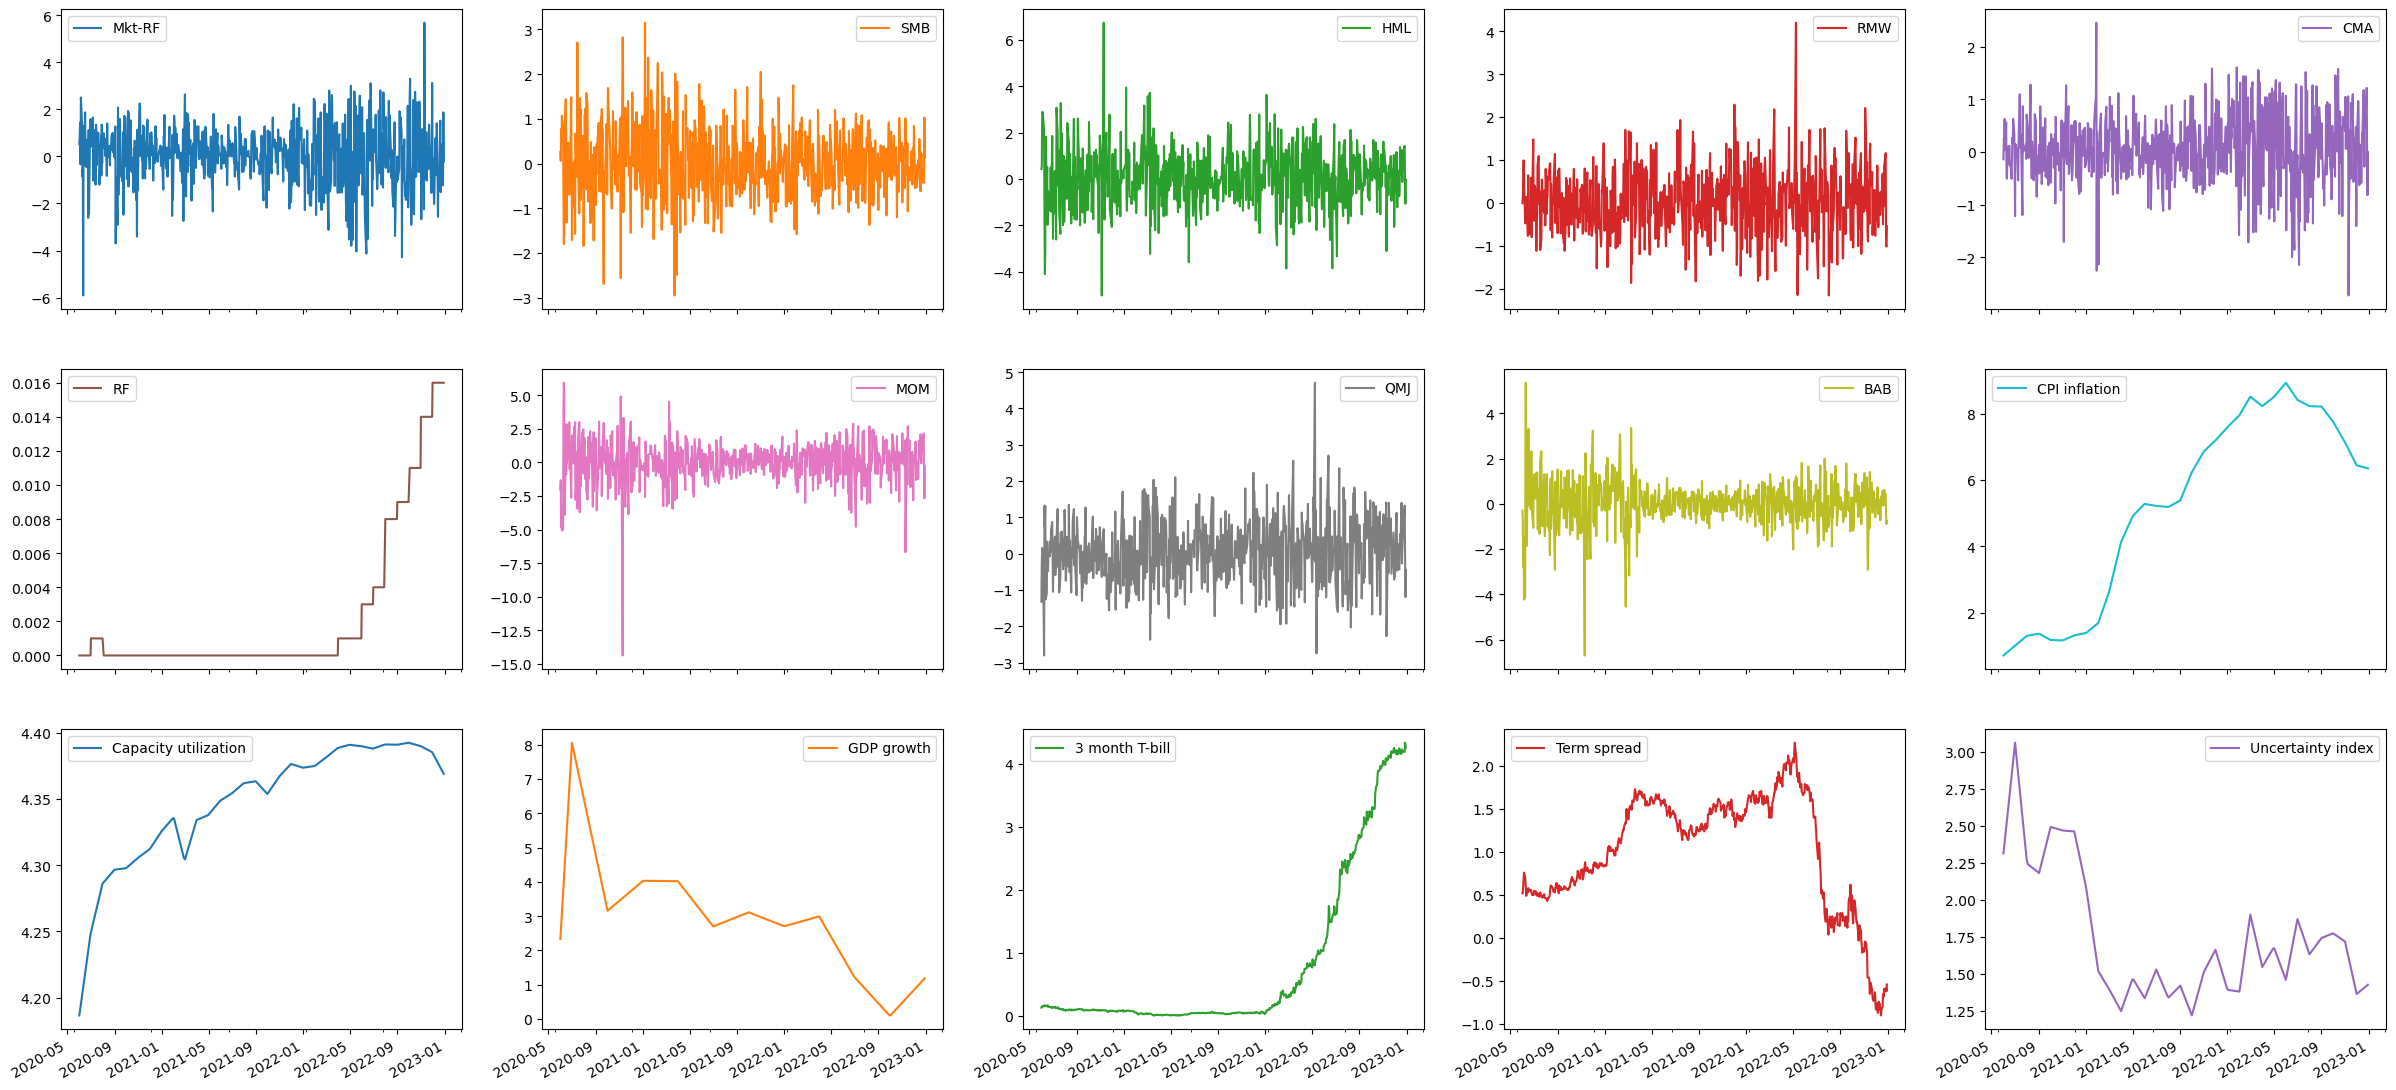

In [6]:
start_date = "2020-06-01"
end_date = "2023-01-01"

factors = pd.concat([ff5f,mom,qmj,bab,cpi_infl,cap_util,gdp_growth,irx,term_spread,uncertainty], axis=1)
factors.index = pd.to_datetime(factors.index)
factors = factors[start_date:end_date].dropna()
factors.plot(subplots=True, layout=(3,5), figsize = (30,15))

We shall start with a linear model for the returns of JPMorgan Equity Premium Income ETF (JEPI), one of the top actively managed ETFs in terms of market capitalization

In [7]:
import statsmodels.api as sm

jepi = yf.Ticker("JEPI").history(start = "2020-05-29", end = end_date)["Close"].rename("JEPI", inplace=True).pct_change()*100
jepi.index = jepi.index.tz_localize(None)
jepi = (jepi - factors["RF"]).dropna()

model = sm.OLS(jepi, sm.add_constant(factors.drop("RF", axis=1))) # add_constant so that our model has an intercept
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     201.2
Date:                Sat, 13 Jan 2024   Prob (F-statistic):          4.28e-223
Time:                        18:26:54   Log-Likelihood:                -181.33
No. Observations:                 653   AIC:                             392.7
Df Residuals:                     638   BIC:                             459.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.4903 

Apparently the market, SMB, CMA, MOM, QMJ and BAB factor all do a very good job of explaining JEPI returns.

Let's try non-Bayesian regularization and feature selection techniques via scikit-learn. We'll start with a ridge regression:

In [8]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=1000)
reg.fit(factors.drop("RF", axis=1),jepi)
reg.coef_.round(4)

array([ 2.54e-01, -1.03e-02, -1.15e-02,  2.51e-02, -7.10e-03, -1.99e-02,
       -1.90e-03,  2.47e-02, -2.30e-03,  2.00e-04,  8.50e-03,  3.30e-03,
       -4.10e-03, -7.00e-04])

The parameter $\alpha$ controls the strength of our regularization. We set it to $\alpha = 1000$ as an example. The case where $\alpha = 0$ is the standard linear regression. 

We can reproduce the example from scikit-learn's user guide (https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) and find feature importance via ridge cross-validation. We must also pay attention to the scale of our variables before interpreting the coefficients. First we take a loot at the standard deviation of the covariates.

<BarContainer object of 15 artists>

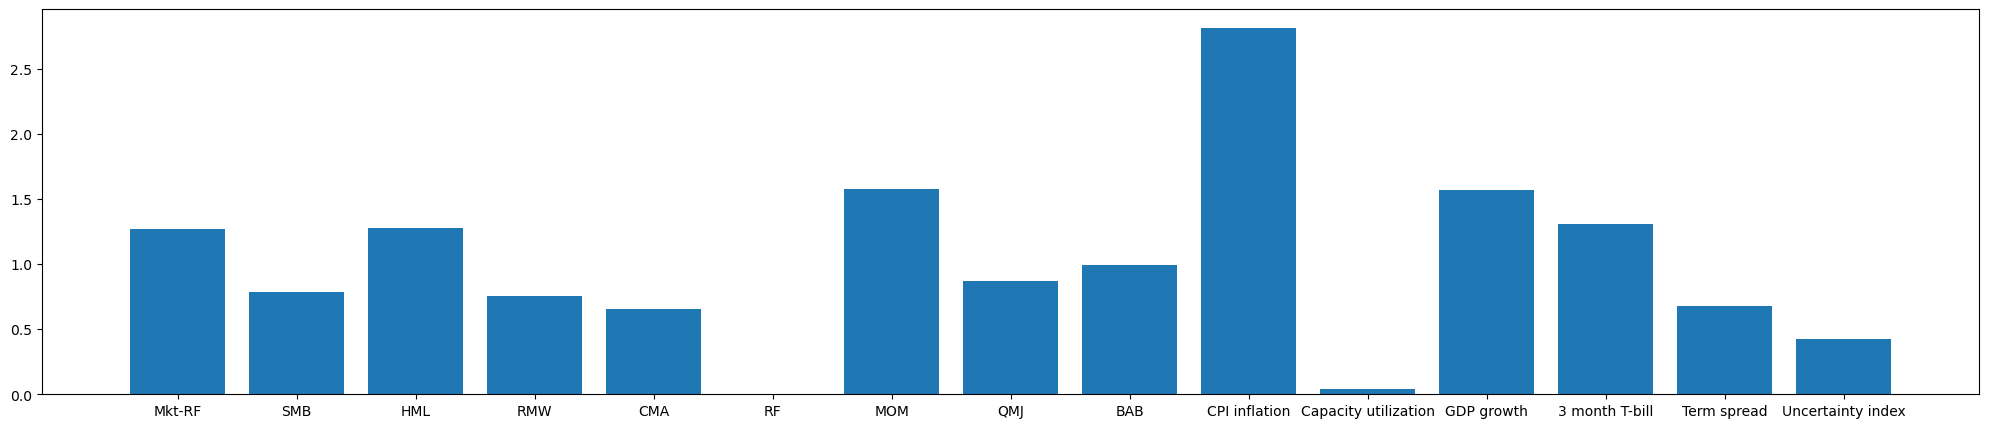

In [9]:
plt.figure(figsize=(25,5))
plt.bar(height = factors.std(), x = factors.std().index)

They have SD values around the same range. Now we try ridge CV:

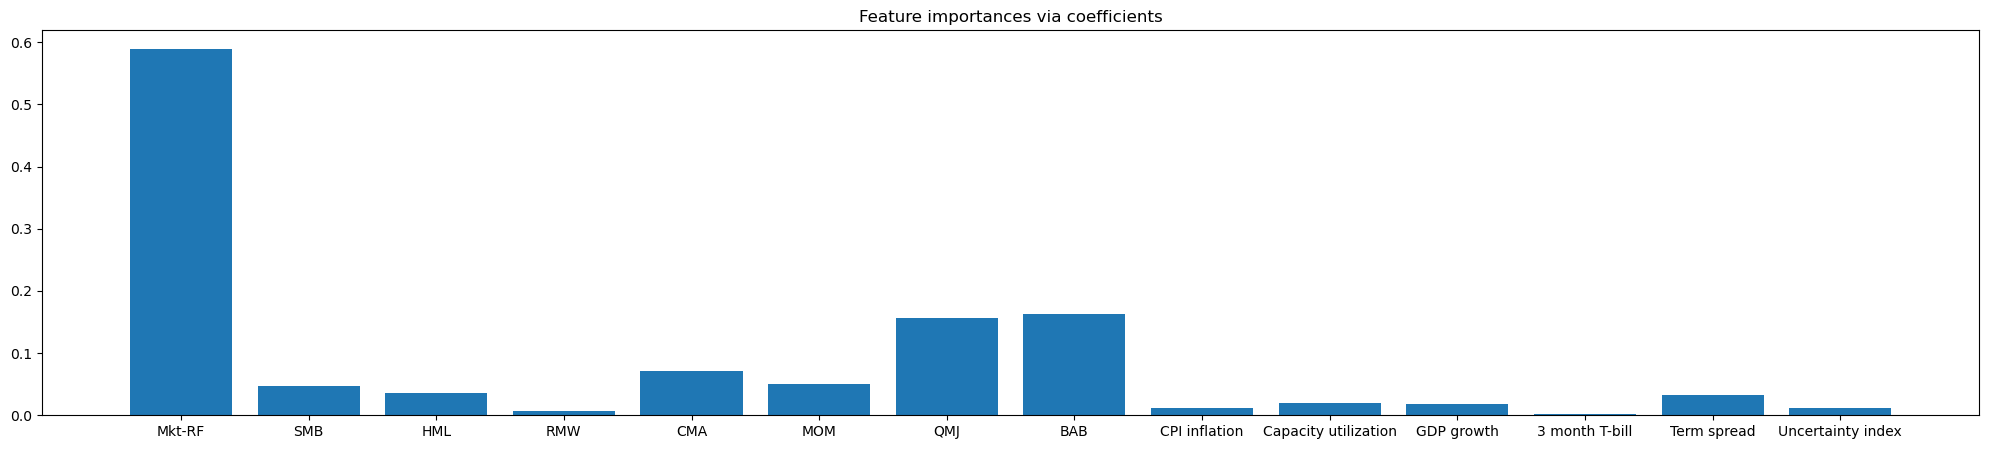

In [10]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.geomspace(1, 10000, num=5)).fit(factors.drop("RF", axis=1), jepi)
importance = np.abs(ridge.coef_)
feature_names = np.array(factors.drop("RF", axis=1).columns)
plt.figure(figsize=(25,5))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In this case, the market factor, QMJ and BAB are the most important variables in explaining JEPI returns throughout the period.

It turns out the ridge regression penalty can be imposed in the Bayesian framework. This would be equivalent to giving the regression coefficients a normal prior distribution. In this case, the standard deviation of the prior would control the strength of the regularization. 

Let's try it out:

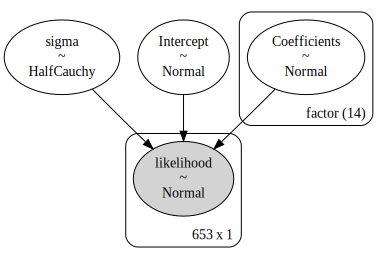

In [14]:
coords = {"factor": factors.drop("RF", axis=1).columns}

with pm.Model(coords=coords) as bayes_ridge:
    alpha = pm.Normal("Intercept", mu=0, sigma=1)
    beta = pm.Normal("Coefficients", mu=0, sigma=1, dims="factor")

    y_mean = alpha + factors.drop("RF", axis=1).values * beta

    obs_noise = pm.HalfCauchy("sigma", beta=1)
    y = pm.Normal("likelihood", mu=y_mean, sigma=obs_noise, observed=jepi.values.reshape((-1,1)))
pm.model_to_graphviz(bayes_ridge)

In [15]:
with bayes_ridge:
    trace_ridge = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Coefficients, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 52 seconds.


In [16]:
az.summary(trace_ridge)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.049,0.009,0.032,0.066,0.0,0.0,28630.0,17643.0,1.0
Coefficients[Mkt-RF],0.496,0.022,0.454,0.536,0.0,0.0,43019.0,14831.0,1.0
Coefficients[SMB],0.039,0.036,-0.027,0.111,0.0,0.0,41578.0,13960.0,1.0
Coefficients[HML],-0.094,0.022,-0.135,-0.052,0.0,0.0,41251.0,14228.0,1.0
Coefficients[RMW],-0.033,0.037,-0.100,0.037,0.0,0.0,41058.0,15073.0,1.0
Coefficients[CMA],-0.234,0.043,-0.316,-0.153,0.0,0.0,40079.0,14905.0,1.0
Coefficients[MOM],-0.064,0.018,-0.097,-0.029,0.0,0.0,36569.0,14607.0,1.0
Coefficients[QMJ],-0.175,0.032,-0.239,-0.116,0.0,0.0,43778.0,15600.0,1.0
Coefficients[BAB],-0.019,0.029,-0.072,0.035,0.0,0.0,41685.0,13863.0,1.0
Coefficients[CPI inflation],-0.004,0.005,-0.013,0.005,0.0,0.0,39007.0,16219.0,1.0


Other than imposing the ridge or LASSO via coefficient priors, we have other Bayesian regularization options.

The spike and slab regression is a common Bayesian variable selection technique. Spike and slab priors can be expressed as a mixture of a discrete distribution that will assign zero to some coefficients (the spike) and a continuous distribution with a larger variance (the slab), which would not be much restrictive of the values the non-zero coefficients can assume. 

The spike and slab can be written as a mixture of normal distributions. The strength of the regularization can be controlled through the hyperparameters for the spike and the slab components.

An example of regression model with a spike and slab prior for $p= 1, \ldots, P$ possible covariates could be written as

$\pi \sim Beta(2,4)$,

$\gamma_p \sim Ber(\pi)$,

$\sigma_{feature} \sim HalfCauchy(1)$,

$\beta_r \sim N(0, \sigma^2_{feature})$,

$\beta_s \sim N(0, 0.000001)$,

$\beta_p = \gamma_p \beta_{r} + (1-\gamma_p) \beta_{s} $,

$\alpha \sim N(0, 1)$,

$\sigma_{obs} \sim HalfCauchy(b)$,

$Y_i \sim N(\alpha + (\gamma_p'\beta_p)' X_i, \sigma^2_{obs})$.

As the Bernoulli distribution is discrete, it cannot be sampled via NUTS algorithm. PyMC then uses the Metropolis algorithm, which is slower and may require more burn-in steps for tuning.

In [ ]:
coords = {"factor": factors.drop("RF", axis=1).columns}

with pm.Model(coords=coords) as ss_model:
    
    pi = pm.Beta("pi", 2, 4)
    gamma = pm.Bernoulli("gamma", p=pi, dims="factor")
    sd_feature = pm.HalfCauchy("sd_feature", 1)
    mix_sd = pm.math.switch(gamma > 0.5, sd_feature, 1e-3)
    
    beta = pm.Normal("Coefficients", mu=0, sigma=mix_sd, dims="factor")
    alpha = pm.Normal("Intercept", mu=0, sigma=1)
    y_mean = alpha + beta * factors.drop("RF", axis=1).values

    obs_noise = pm.HalfCauchy("sigma_obs", beta=1)
    y = pm.Normal("likelihood", mu=y_mean, sigma=obs_noise, observed=jepi.values.reshape((-1,1)))
pm.model_to_graphviz(ss_model)

In [ ]:
with ss_model:
    trace_ss = pm.sample(5000, tune=2000, target_accept=0.95, return_inferencedata=True)

In [ ]:
az.plot_trace(trace_ss)

Another type of prior distribution well-suited for shrinkage and variable selection are global-local priors. These priors consist of two components: one global, that shrinks all coefficients towards zero, and one local for each covariate, that will allow the largest coefficients to escape zero. 

One famous example of global-local prior is the horseshoe prior. The original horseshoe prior (http://proceedings.mlr.press/v5/carvalho09a/carvalho09a.pdf) is a mixture of two half-Cauchy distributions for each local plus the global components. 

Another version called regularized horseshoe (https://arxiv.org/pdf/1707.01694.pdf) combines elements of the original horseshoe and the spike and slab. The regularized horseshoe imposes regularization on both small and large coefficients. As the regularized horseshoe is relatively new, the best ways to implement it are current subject of research, and NUTS sampling can result in some divergent transitions (https://discourse.mc-stan.org/t/divergent-transitions-with-the-horseshoe-prior/1651/2). 

A model with the original horseshoe prior for $p = 1, \ldots, P$ possible covariates can look like

$\tau_0 = \frac{p_0}{P-p_0}\sigma_{obs}$,

$\tau \sim HalfNormal(\tau_0^2)$,

$\lambda_p \sim HalfCauchy(1)$,

$\beta_p \sim N(0, \lambda_p^2 \tau^2)$,

$\alpha \sim N(0, 1)$,

$Y_i \sim N(\alpha + \beta_p' X_i, \sigma^2_{obs})$,

where $p_0$ is our initial guess for the number of nonzero coefficients (we set it to 7), the hyperparameter of the $\lambda_p$ components are scaled by the standard deviation of the observed variables and $\sigma_{obs}$ is fixed and set to $0.01$. We also use the noncentered parametrization for hierarchical models. 

There are many techniques for the global shrinkage parameter $\tau$. We follow Piironen and Vehtari (2017) in specifying it as a function of $\tau_0$, and then use $\tau_0$ as the standard deviation of a half-normal prior.

In [ ]:
coords = {"factor": factors.drop("RF", axis=1).columns}

with pm.Model(coords=coords) as hs_model:

    obs_noise = 0.01
    p0 = 7
    D = len(factors.drop("RF", axis=1).columns)
    tau0 = (p0/(D-p0))*obs_noise
    
    tau = pm.HalfNormal("tau", sigma=tau0)
    lamb = pm.HalfCauchy('lambda', 1/(factors.drop("RF", axis=1).std().values), dims="factor")

    z = pm.Normal('z', 0, 1, dims="factor")
    beta = pm.Deterministic("Coefficients", pm.math.dot(tau,lamb) * z, dims="factor")
    alpha = pm.Normal("Intercept", mu=0, sigma=1)

    y_mean = alpha + beta * factors.drop("RF", axis=1).values

    obs_noise = pm.HalfCauchy("sigma_obs", beta=0.1)
    y = pm.Normal("likelihood", mu=y_mean, sigma=obs_noise, observed=jepi.values.reshape((-1,1)))
pm.model_to_graphviz(hs_model)

In [ ]:
with hs_model:
    trace_hs = pm.sample(5000, tune=3000, target_accept=0.95, return_inferencedata=True)

In [ ]:
az.plot_trace(trace_hs, var_names=['~z'])

In [19]:
az.summary(trace_hs, var_names=["~z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.048,0.008,0.033,0.063,0.000,0.000,15449.0,10207.0,1.0
tau,0.015,0.006,0.005,0.026,0.000,0.000,6517.0,7276.0,1.0
lambda[Mkt-RF],42.731,42.171,6.096,110.363,0.689,0.487,5280.0,4439.0,1.0
lambda[SMB],1.956,3.693,0.000,5.612,0.033,0.023,13471.0,9131.0,1.0
lambda[HML],7.685,10.734,0.477,19.997,0.126,0.089,6994.0,9268.0,1.0
lambda[RMW],1.838,3.484,0.000,5.171,0.029,0.020,12916.0,8839.0,1.0
lambda[CMA],20.899,28.405,2.184,53.642,0.346,0.244,6954.0,9024.0,1.0
lambda[MOM],4.663,6.878,0.002,12.587,0.071,0.050,6212.0,5752.0,1.0
lambda[QMJ],15.428,22.919,1.401,38.699,0.278,0.197,6216.0,7716.0,1.0
lambda[BAB],1.315,2.436,0.000,3.824,0.022,0.015,10404.0,7279.0,1.0


The regularized horseshoe model from Piironen and Vehtari (2017) differs from the original horseshoe in that it adds an additional shrinkage component $c^2$, to which the authors assign an inverse gamma distribution.

We specify the following model with the regularized horseshoe

$\tau_0 = \frac{p_0}{P-p_0}\sigma_{obs}$,

$\tau \sim HalfNormal(\tau_0^2)$,

$\lambda_p \sim HalfCauchy(1)$,

$c^2 \sim  InvGamma(\frac{\nu}{2}, \frac{\nu s}{2})$

$\xi_p^2 = \frac{c^2 \lambda_p^2}{c^2 + \tau^2 \lambda_p^2}$,

$\beta_p \sim N(0, \tau^2 \xi^2)$,

$\alpha \sim N(0, 1)$,

$Y_i \sim N(\alpha + \beta_p' X_i, \sigma^2_{obs})$,

where $\nu$ and $s$ are, respectively, the degrees of freedom and scale parameters of a scaled inverse chi-squared distribution, here parametrized as the equivalent inverse gamma distribution. 

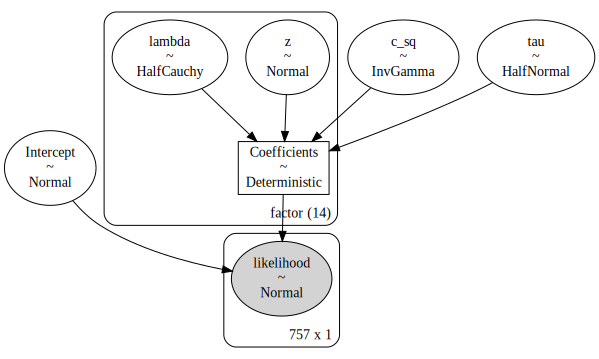

In [44]:
coords = {"factor": factors.drop("RF", axis=1).columns}

with pm.Model(coords=coords) as reg_hs_model:

    obs_noise = 0.01
    p0 = 7
    D = len(factors.drop("RF", axis=1).columns)
    tau0 = (p0/(D-p0))*obs_noise
    
    tau = pm.HalfNormal("tau", sigma=tau0)
    lamb = pm.HalfCauchy('lambda', 1/(factors.drop("RF", axis=1).std().values), dims="factor")

    c_df = 4
    c_scale = 1
    c_sq = pm.InverseGamma("c_sq", c_df * 0.5, c_df * c_scale * 0.5)
    c = pm.math.sqrt(c_sq)
    xi = (pm.math.dot(c,lamb)/(c + pm.math.dot(tau, lamb)))

    z = pm.Normal('z', 0, 1, dims="factor")
    beta = pm.Deterministic("Coefficients", pm.math.dot(tau,xi) * z, dims="factor")
    alpha = pm.Normal("Intercept", mu=0, sigma=1)

    y_mean = alpha + beta * factors.drop("RF", axis=1).values

    y = pm.Normal("likelihood", mu=y_mean, sigma=obs_noise, observed=jepi.values.reshape((-1,1)))
pm.model_to_graphviz(reg_hs_model)

In [45]:
with reg_hs_model:
    trace_rhs = pm.sample(5000, tune=5000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda, c_sq, z, Intercept]



KeyboardInterrupt



In [ ]:
az.plot_trace(trace_rhs, var_names=['~z'])

We can estimate a Bayesian model with flat priors (that will have the same results as OLS) and compare the coefficients for each variable and all 5 regularization techniques

In [ ]:
with pm.Model(coords=coords) as bayes_flat:
    alpha = pm.Normal("Intercept", mu=0, sigma=1e4)
    beta = pm.Normal("Coefficients", mu=0, sigma=1e4, dims="factor")
    
    y_mean = alpha + factors.drop("RF", axis=1).values * beta

    obs_noise = pm.HalfCauchy("sigma", beta=1)
    y = pm.Normal("likelihood", mu=y_mean, sigma=obs_noise, observed=jepi.values.reshape((-1,1)))
    trace_flat = pm.sample(5000, tune=2000, return_inferencedata=True)

In [ ]:
az.plot_forest([trace_ridge, trace_flat, trace_ss, trace_hs, trace_rhs], model_names = ["Ridge (normal)", "Flat (OLS)", "Spike and slab", "Original HS", "Regularized HS"], var_names=["Coefficients"], combined=True, hdi_prob=0.95)

## Additional references for this section

Rubin, Donald B. "Estimation in parallel randomized experiments." Journal of Educational Statistics 6.4 (1981): 377-401.

Piironen, Juho, and Aki Vehtari. "Sparsity information and regularization in the horseshoe and other shrinkage priors." Electronic Journal of Statistics 11.2 (2017): 5018-5051.